In [23]:
import json
import csv
import matplotlib.pyplot as plt

In [2]:
def get_json(path : str):
    with open(path, "r") as f:
        return json.load(f)

In [3]:
def save_json(obj : any, path : str):
    with open(path, "w+") as f:
        json.dump(obj, f)

In [4]:
def save_csv(obj : list, path : str):
    headers = obj[0].keys() 
    with open(path, "w+") as f:
        writer = csv.DictWriter(f, headers)
        writer.writeheader()
        writer.writerows(obj)

In [5]:
legislators = get_json("data/recent_legislators_map.json")

In [6]:
senate_bills = get_json("data/senate_bills.json")

In [7]:
house_bills = get_json("data/house_bills.json")

In [8]:
def set_cosponsor_counts(bills : list):
    for bill in bills:
        sponsor = bill["sponsor"]
        if "thomas_id" in sponsor and sponsor["thomas_id"] in legislators:
            sponsor["party"] = legislators[sponsor["thomas_id"]]["party"]
        elif "bioguide_id" in sponsor and sponsor["bioguide_id"] in legislators:
            sponsor["party"] = legislators[sponsor["bioguide_id"]]["party"]
        else:
            sponsor["party"] = "unknown"
        cosponsor_party_count = {}
        for cosponsor in bill["cosponsors"]: 
            if "thomas_id" in cosponsor and cosponsor["thomas_id"] in legislators:
                cosponsor["party"] = legislators[cosponsor["thomas_id"]]["party"]
            elif "bioguide_id" in cosponsor and cosponsor["bioguide_id"] in legislators:
                cosponsor["party"] = legislators[cosponsor["bioguide_id"]]["party"]
            else:
                cosponsor["party"] = "unknown"
            if cosponsor["party"] not in cosponsor_party_count:
                cosponsor_party_count[cosponsor["party"]] = 0
            cosponsor_party_count[cosponsor["party"]] += 1
        bill["total_cosponsors"] = len(bill["cosponsors"])
        bill["cosponsor_party_count"] = cosponsor_party_count

In [9]:
set_cosponsor_counts(senate_bills)
set_cosponsor_counts(house_bills)

In [10]:
parties = list(set([leg["party"] for leg in legislators.values()]))
parties

['Popular Democrat',
 'Independent',
 'multiple',
 'Democrat',
 'Republican',
 'New Progressive',
 'Conservative']

In [11]:
cosponsor_count_info = []
for bill in senate_bills + house_bills:
    count_info = {
        "bill_id" : bill["bill_id"],
        "type" :  bill["bill_type"],
        "sponsor_party" : bill["sponsor"]["party"],
        "congress" : bill["congress"]
    }
    for party in parties + ["unknown"]:
        count_info[party] = bill["cosponsor_party_count"][party] if party in bill["cosponsor_party_count"] else 0
    cosponsor_count_info.append(count_info)

In [ ]:
save_csv(cosponsor_count_info, "data/cosponsor_party_count.csv")

In [43]:
cosponsored_bill_counts = {}

In [44]:
for count_info in cosponsor_count_info:
    if count_info["congress"] not in cosponsored_bill_counts:
        cosponsored_bill_counts[count_info["congress"]] = {
            "hr" : {
                "total_bills" : 0, 
                "opposite_cosponsored" : 0,
                "total_opposite_cosponsors" : 0,
                "total_allied_cosponsors" : 0,
                "opposite_cosponsors_prop" : 0
            },
            "s" : {
                "total_bills" : 0,
                "opposite_cosponsored" : 0,
                "total_opposite_cosponsors": 0,
                "total_allied_cosponsors" : 0, 
                "opposite_cosponsors_prop" : 0
            }
        }
    counter = cosponsored_bill_counts[count_info["congress"]][count_info["type"]]
    if count_info["sponsor_party"] == "Democrat": 
        counter["total_bills"] += 1
        if count_info["Republican"] > 0:
            counter["opposite_cosponsored"] += 1
        counter["total_opposite_cosponsors"] += count_info["Republican"]
        counter["total_allied_cosponsors"] += count_info["Democrat"]
        counter["opposite_cosponsors_prop"] += count_info["Republican"] / (count_info["Democrat"] + count_info["Republican"] + 1)
    elif count_info["sponsor_party"] == "Republican":
        counter["total_bills"] += 1
        if count_info["Democrat"] > 0: 
            counter["opposite_cosponsored"] += 1
        counter["total_opposite_cosponsors"] += count_info["Democrat"]
        counter["total_allied_cosponsors"] += count_info["Republican"]
        counter["opposite_cosponsors_prop"] += count_info["Democrat"] / (count_info["Democrat"] + count_info["Republican"] + 1)
            
        

In [46]:
congress_nos = range(93, 116)

In [47]:
house_op_share_xs = [cosponsored_bill_counts[str(no)]["hr"]["opposite_cosponsored"] / cosponsored_bill_counts[str(no)]["hr"]["total_bills"] for no in congress_nos]


In [48]:
senate_op_share_xs =  [cosponsored_bill_counts[str(no)]["s"]["opposite_cosponsored"] / cosponsored_bill_counts[str(no)]["s"]["total_bills"] for no in congress_nos]

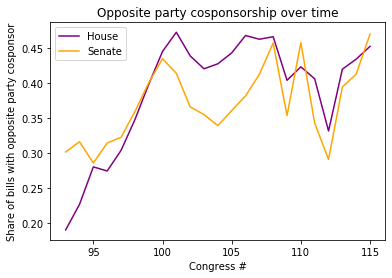

In [57]:
plt.plot(congress_nos, house_op_share_xs, "-", color="purple")
plt.plot(congress_nos, senate_op_share_xs, "-", color ="orange")
plt.legend(["House", "Senate"])
plt.title("Opposite party cosponsorship over time")
plt.xlabel("Congress #")
plt.ylabel("Share of bills with opposite party cosponsor")
plt.show()

In [50]:
total_house_bills = [cosponsored_bill_counts[str(no)]["hr"]["total_bills"] for no in congress_nos]
total_senate_bills = [cosponsored_bill_counts[str(no)]["s"]["total_bills"] for no in congress_nos]

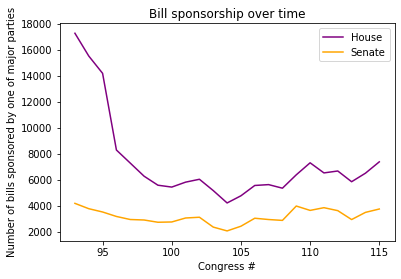

In [53]:
plt.plot(congress_nos, total_house_bills, "-", color="purple")
plt.plot(congress_nos, total_senate_bills, "-", color ="orange")
plt.legend(["House", "Senate"])
plt.title("Bill sponsorship over time")
plt.xlabel("Congress #")
plt.ylabel("Number of bills sponsored by one of major parties")
plt.show()

In [55]:
house_op_prop_xs = [cosponsored_bill_counts[str(no)]["hr"]["opposite_cosponsors_prop"] / cosponsored_bill_counts[str(no)]["hr"]["total_bills"] for no in congress_nos]
senate_op_prop_xs =  [cosponsored_bill_counts[str(no)]["s"]["opposite_cosponsors_prop"] / cosponsored_bill_counts[str(no)]["s"]["total_bills"] for no in congress_nos]

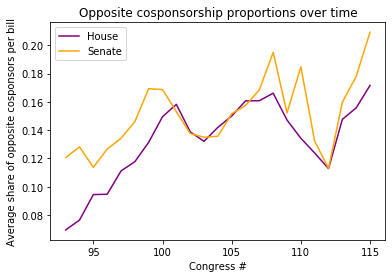

In [56]:
plt.plot(congress_nos, house_op_prop_xs, "-", color="purple")
plt.plot(congress_nos, senate_op_prop_xs, "-", color ="orange")
plt.legend(["House", "Senate"])
plt.title("Opposite cosponsorship proportions over time")
plt.xlabel("Congress #")
plt.ylabel("Average share of opposite cosponsors per bill")
plt.show()

In [59]:
house_avg_cosponsors = [(cosponsored_bill_counts[str(no)]["hr"]["total_opposite_cosponsors"] + cosponsored_bill_counts[str(no)]["hr"]["total_allied_cosponsors"])  / cosponsored_bill_counts[str(no)]["hr"]["total_bills"] for no in congress_nos]

In [60]:
senate_avg_cosponsors = [(cosponsored_bill_counts[str(no)]["s"]["total_opposite_cosponsors"] + cosponsored_bill_counts[str(no)]["s"]["total_allied_cosponsors"])  / cosponsored_bill_counts[str(no)]["s"]["total_bills"] for no in congress_nos]

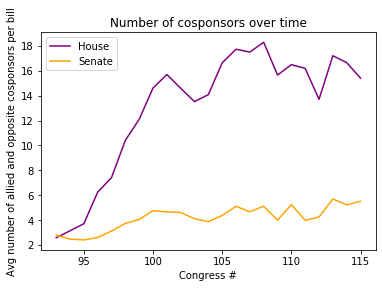

In [61]:
plt.plot(congress_nos, house_avg_cosponsors, "-", color="purple")
plt.plot(congress_nos, senate_avg_cosponsors, "-", color ="orange")
plt.legend(["House", "Senate"])
plt.title("Number of cosponsors over time")
plt.xlabel("Congress #")
plt.ylabel("Avg number of allied and opposite cosponsors per bill")
plt.show()

In [2]:
sorted((2, 1))

[1, 2]